In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Import Data and images

In [2]:
! pip install gdown
! mkdir -p /content/pic/
! gdown -O /content/pictures_small.tar "1--wMVbrubESyAz_nU8SuAKdTNCom7frI"

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Downloading...
From: https://drive.google.com/uc?id=1--wMVbrubESyAz_nU8SuAKdTNCom7frI
To: /content/pictures_small.tar
100% 86.8M/86.8M [00:00<00:00, 228MB/s]


In [3]:
import tarfile
try: 
  tar = tarfile.open('/content/pictures_small.tar')
  tar.extractall(path='/content/pic')
  tar.close()
except:
  print("Pictures could not be extracted")

In [4]:
! mv /content/pic/content/pic/* /content/pic/
! rmdir /content/pic/content

rmdir: failed to remove '/content/pic/content': Directory not empty


In [5]:
path_to_pictures = '/content/pic/'
path_to_dataset = '/content/drive/MyDrive/Colab Notebooks/CVNLP/dataset_faces_small.csv'

In [6]:
!pip install torch torchvision

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [7]:
import pandas as pd
import numpy as np
import torchvision.transforms as T
import matplotlib.pyplot as plt
from PIL import Image
import torch

In [8]:
df = pd.read_csv(path_to_dataset)

In [9]:
df.head()

,filename,age,gender,ethnicity
0,36_1_1_20170116161213859.jpg,36,1,1
1,36_1_1_20170116160832540.jpg,36,1,1
2,36_1_1_20170116165713429.jpg,36,1,1
3,37_0_1_20170116194434755.jpg,37,0,1
4,37_0_1_20170117164514945.jpg,37,0,1


In [10]:
df.shape

(1250, 4)

## Get pictures as numpy arrays

In [11]:
# WARNING: This might take long
from tqdm import tqdm
from pathlib import Path
images = []

for image in tqdm(df['filename']):
  path = path_to_pictures + image
  try: 
    img = Image.open(path).convert('L') # I use that to make sure all the pictures are RGB
    images.append(img)
    #img = np.array(img)
  except FileNotFoundError as e:
    print(e)
  

100%|██████████| 1250/1250 [00:26<00:00, 46.63it/s]


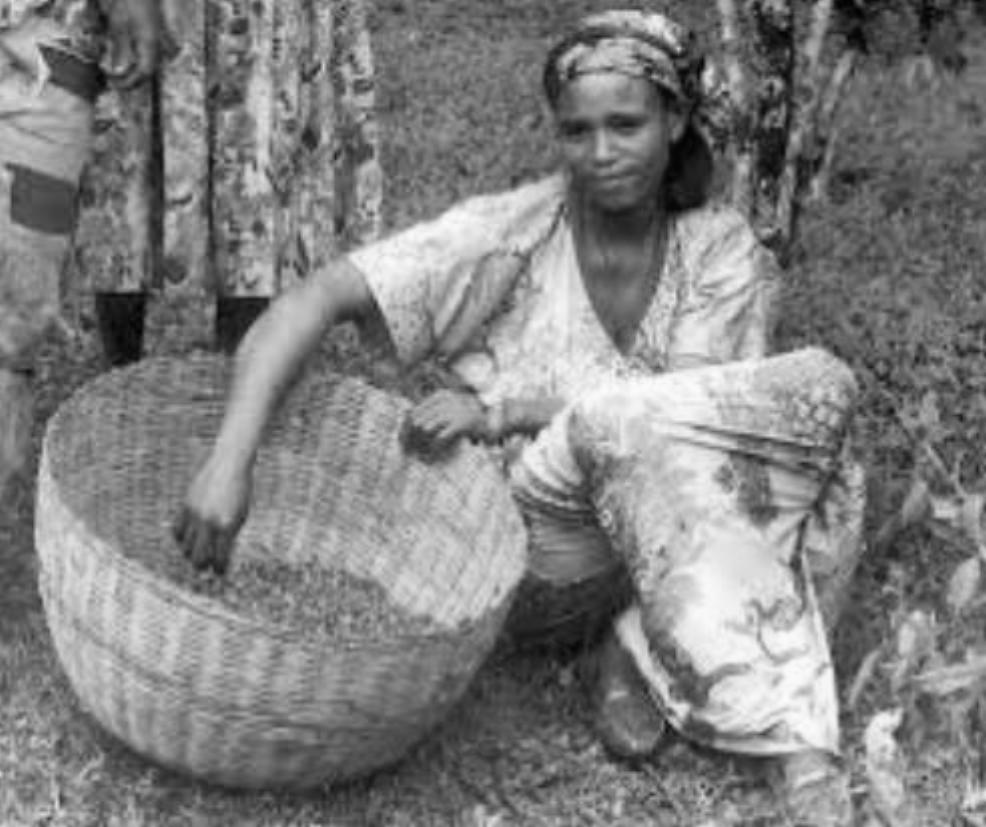

In [13]:
images[0]

In [23]:
# Check sizes
for idx, img in enumerate(images[0:5]):
  img_array = np.array(img)
  print(f"Image {idx} has shape {img_array.shape}")

Image 0 has shape (827, 986)
Image 1 has shape (779, 1042)
Image 2 has shape (1039, 782)
Image 3 has shape (1103, 738)
Image 4 has shape (779, 1042)


# Normalize Pictures with PyTorch

The normalization can constitute an effective way to speed up the computation in the model based on neural network architecture and learn faster by reducing the skewness. 

There are 2 steps to normalize the images: 


1.   Substract the channel mean from each input channel
2.   Dived it by the channel standard deviation

When we transformed an image into a PyTorch tensor, the pixel values are scaled between 0 and 1. In PyTorch, this transformation is done usint torchvision.transforms.ToTensor(). This converts the PIL image with a pixel range of 0 to 255 to a PyTorch FloatTensor of shape (C, H, W) with a range from 0 to 1. 

**Normalizing the images means transforming the images into such values that the mean and stadard deviation of the image become 0 and 1 respectively.**

To actually normalize the image, then we use torchvision.transforms.Normalize(). 

Normalize() takes 2 parameters: 
* mean: Sequeance of means for each channel. 
* std. Sequence of standard deviations for each channel. 
And it returns a normalized tensor image. 

To normalize the image we first calculate the mean and standard deviation of 10 random pictures. 

In [14]:
# Transform images to tensor images: 
tensor_images = []
for idx, img in enumerate(images):
  tensor_img = (T.ToTensor())(img) # Transform image to pixel values btw 0 and 1
  tensor_images.append(tensor_img)

Text(0.5, 1.0, 'distribution of pixels for first picture')

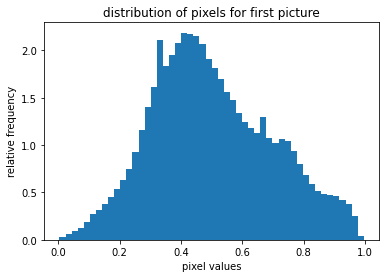

In [15]:
# Plot pixel values of first image: 
array_img = np.array(tensor_images[0])

plt.hist(array_img.ravel(), bins=50, density=True)
plt.xlabel('pixel values')
plt.ylabel('relative frequency')
plt.title('distribution of pixels for first picture')

In [19]:
# Calculate mean and standard deviation for 10 random pictures: 
import random
mean_pixels = torch.zeros([3, 10])
std_pixels = torch.zeros([3, 10])

for idx, img in enumerate(random.sample(tensor_images, k=10)):
  mean = img.mean([1,2])
  std = img.std([1,2])
  mean_pixels[:, idx] = mean 
  std_pixels[:, idx] = std

mean = mean_pixels.mean(1)
std = std_pixels.mean(1)

print(f"Mean of 10 random images: {mean}")
print(f"Std of 10 random images: {std}")

Mean of 10 random images: tensor([0.5350, 0.5350, 0.5350])
Std of 10 random images: tensor([0.2568, 0.2568, 0.2568])


In [17]:
normalized_images_tensor = []
# normalized_images = []

# Instanciate Normalize() function with calculated mean and std
normalizer = T.Normalize(mean=list(mean), std=list(std))

for idx, img in enumerate(tensor_images):
  try: 
    normalized_img = normalizer(img)
    normalized_images_tensor.append(normalized_img)
    #normalized_img = T.ToPILImage()(normalized_img)
    #normalized_images.append(normalized_img)
  except RuntimeError as e:
    # delete from the df: it is not working but i do not know why
    # df = df.drop(index=idx)
    print(f"Normalization failed in index {idx}: {e}")
    print("Picture will be converted or deleted.")


Normalization failed in index 0: output with shape [1, 827, 986] doesn't match the broadcast shape [3, 827, 986]
Picture will be converted or deleted.
Normalization failed in index 1: output with shape [1, 779, 1042] doesn't match the broadcast shape [3, 779, 1042]
Picture will be converted or deleted.
Normalization failed in index 2: output with shape [1, 1039, 782] doesn't match the broadcast shape [3, 1039, 782]
Picture will be converted or deleted.
Normalization failed in index 3: output with shape [1, 1103, 738] doesn't match the broadcast shape [3, 1103, 738]
Picture will be converted or deleted.
Normalization failed in index 4: output with shape [1, 779, 1042] doesn't match the broadcast shape [3, 779, 1042]
Picture will be converted or deleted.
Normalization failed in index 5: output with shape [1, 1119, 730] doesn't match the broadcast shape [3, 1119, 730]
Picture will be converted or deleted.
Normalization failed in index 6: output with shape [1, 1115, 730] doesn't match the 

KeyboardInterrupt: ignored

In [ ]:
print(f"Normalized lists lenght is {len(normalized_images_tensor)}")
print(f"df shape is {df.shape}")

In [ ]:
#print(normalized_images[0])

In [ ]:
#normalized_images[0]

In [ ]:
#print(normalized_images_tensor[0])

# Convolutional neural network


Advantages of CNN: 
* Fewer parameters are necessary to train the model. The kernel is used to calculate the outputs of the entire image, so the model has much fewer parameters compared to a fully connected layer. 
* For classification we do not need to consider all the relations between the feature. 
* Fully connected neural networks are big and therefore computationally inefficient. 
* With CNN the unit share weights (the kernel), which makes the model more eficcient. 
* Sparsity of connections: In each layer, each output element only depends on a small number of input elements, which makes the forward and backward passes more efficient. 
* Parameter sharing and spatial invariance: The features learned by a kernel in one part of the image can be used to detect a similar pattern in a different part of another image. 

Sources: 
* https://towardsdatascience.com/intuitively-understanding-convolutions-for-deep-learning-1f6f42faee1
* https://medium.com/analytics-vidhya/image-classification-with-pytorch-184e76c2cf3b

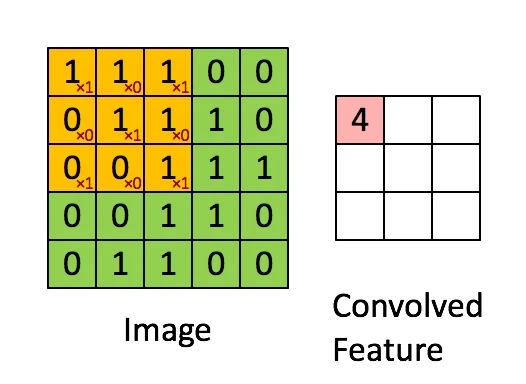

Source: https://giphy.com/gifs/blog-daniel-keypoints-i4NjAwytgIRDW



## 1) Prepare Data

### Get Tensordataset

In [ ]:
# Get target (gender): 
tensor_y = np.array(df['age'])
tensor_y = torch.from_numpy(tensor_y)

In [ ]:
# Get features (images)
X = normalized_images_tensor
X[0].shape

In [ ]:
# X is a list of tensors. In this cell we transform X from list into a tensor itself. 
tensor_X = torch.zeros(len(X), 3, img_size[0], img_size[1])
for idx, x in enumerate(X):
  tensor_X[idx] = x 

In [ ]:
from torch.utils.data import TensorDataset
tensor_ds = TensorDataset(tensor_X, tensor_y)

In [ ]:
len(tensor_ds)

In [ ]:
img, label = tensor_ds[4]
print(img.shape, label)

In [ ]:
plt.imshow(img.permute(1, 2, 0))
plt.show()

### Split dataset with PyTorch

In [ ]:
from torch.utils.data import random_split
# Random numbers will be generated always on the same way, so we can compare models. 
random_seed = 42
torch.manual_seed(random_seed)

20% of the images will be used for validate the model. 

In [ ]:
# split dataset with PyTorch
test_size = int(len(tensor_ds) * 0.2)
train_size = len(tensor_ds) - test_size
print(f"Dataset has length {len(tensor_ds)}, train set has length {train_size} and test set has length {test_size}.")
print(f"Total length is {train_size + test_size}.")

In [ ]:
train_ds, test_ds = random_split(tensor_ds, [train_size, test_size])
print(len(train_ds))
print(len(test_ds))

In [ ]:
# Load the data
from torch.utils.data import DataLoader
batch_size=5
train_loader = DataLoader(train_ds, batch_size, shuffle=True, num_workers=4)
test_loader = DataLoader(test_ds, batch_size)

The dataloader allows to split the data into batches of a predifined size while training. The pictures for the dataloader will be randomly selected (shuffle=True)

In [ ]:
# Show a batch of data: 
from torchvision.utils import make_grid

def show_batch(dataloader): 
  for images, labels in dataloader:
    fg, ax = plt.subplots(figsize=(12,6))
    ax.set_xticks([])
    ax.set_yticks([])
    ax.imshow(make_grid(images, nrow=16).permute(1, 2, 0))
    break;


In [ ]:
show_batch(train_loader)

## 2) Create Model

In [ ]:
# Define initial number of kernels. 
num_kernels = img_size[0]
num_kernels
X[0].shape

In [ ]:
from torch import nn

class Model(nn.Module): 
  def __init__(self): 
    super().__init__()
    self.network = nn.Sequential(
        nn.Conv2d(3, num_kernels, kernel_size=3, padding=1),
        nn.ReLU(), 
        nn.Conv2d(num_kernels, num_kernels*2, kernel_size=3, stride=1, padding=1),
        nn.ReLU(),
        nn.MaxPool2d(2,2), # Output: 64x16x16
        #MaxPool reduce the size of the image by half (if it was 32x32, becomes 16x16)

        nn.Conv2d(num_kernels*2, num_kernels*4, kernel_size=3, padding=1, stride=1),
        nn.ReLU(), 
        nn.Conv2d(num_kernels*4, num_kernels*4, kernel_size=3, stride=1, padding=1),
        nn.ReLU(),
        nn.MaxPool2d(2,2), # Output: 128x8x8

        nn.Conv2d(num_kernels*4, num_kernels*8, kernel_size=3, stride=1, padding=1),
        nn.ReLU(), 
        nn.Conv2d(num_kernels*8, num_kernels*8, kernel_size=3, stride=1, padding=1),
        nn.ReLU(),
        # MaxPool2d reduces the image of a picture by half
        nn.MaxPool2d(2,2), # Output: 256x4x4

        # Flatten() reduces the 3 dimensions in one dimension. 
        nn.Flatten(), # 5x32768
        nn.Linear(num_kernels*8 *4*4*4, num_kernels*8*4*4), #32.768 , 8.192
        nn.ReLU(),
        nn.Linear(num_kernels*8*4*4, num_kernels*4*4),# 8.192, 1024
        nn.ReLU(),
        nn.Linear(num_kernels*4*4, 120)) #1024, 120
    
  def forward(self, x):
    return self.network(x)

## 3) Train the model

In [ ]:
def fit(model, train_loader, num_epochs, optimizer, loss_function):
  log = {}
  # Tell the model we are in training mode. 
  model.train()

  for epoch in range(num_epochs): # for each number of epochs. 
    losses = []
    for x, y in train_loader: # for each batch in the train loader: 
      optimizer.zero_grad()
      prediction = model(x)
      loss = loss_function(prediction, y)
      losses.append(loss)
      loss.backward()
      optimizer.step()
    log[epoch] = sum(losses) / len(losses)
    print(f"Epoch [{epoch}/{num_epochs}] loss: {log[epoch]}.")



In [ ]:
# Use Google Collabs GPU
def get_device():
  if torch.cuda.is_available():
    return torch.device('cuda')
  else:
    return torch.device('cpu')

In [ ]:
def to_device(data, device):
  if isinstance(data, (list, tuple)):
    return [to_device(x, device) for x in data]
  return data.to(device, non_blocking=True)

In [ ]:
# Initialize the model
# model = to_device(Model(), get_device()) 
model = Model()

# Create Optimizer
optimizer = torch.optim.Adam(model.parameters(), 1e-5)
# Other optimizer could be the stochastic gradient descent
# torch.optim.SGD(model.parameters(), lr=1e-5)

# define loss function
loss_function = nn.CrossEntropyLoss()

# Train the model using the function above: 
fit(model, train_loader, 10, optimizer, loss_function)

In [ ]:
def evaluate(loader, name="Training"):
  # Get predictions
  correct, total = 0, 0 
  predictions = []

  # This tells PyTorch that the model is in evalution mode. 
  model.eval() 
  for idx, (x, y) in enumerate(loader):
    output = model(x)
    max_prob, prediction = torch.max(output, 1)
    predictions.append(output)
    total += y.size(0)
    correct += (prediction == y).sum().item()

  accuracy = correct/ total 
  print(f"{name} Accuracy is {accuracy * 100:.2f}%")

evaluate(train_loader)
evaluate(test_loader, "Testing")

In [ ]:
# Source: 
# https://www.analyticsvidhya.com/blog/2019/12/image-augmentation-deep-learning-pytorch/